In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bvp_to_hr import read_data, find_heart_rate, find_peaks
import os
from gsr import get_gsr_summary
import warnings
warnings.simplefilter("ignore")

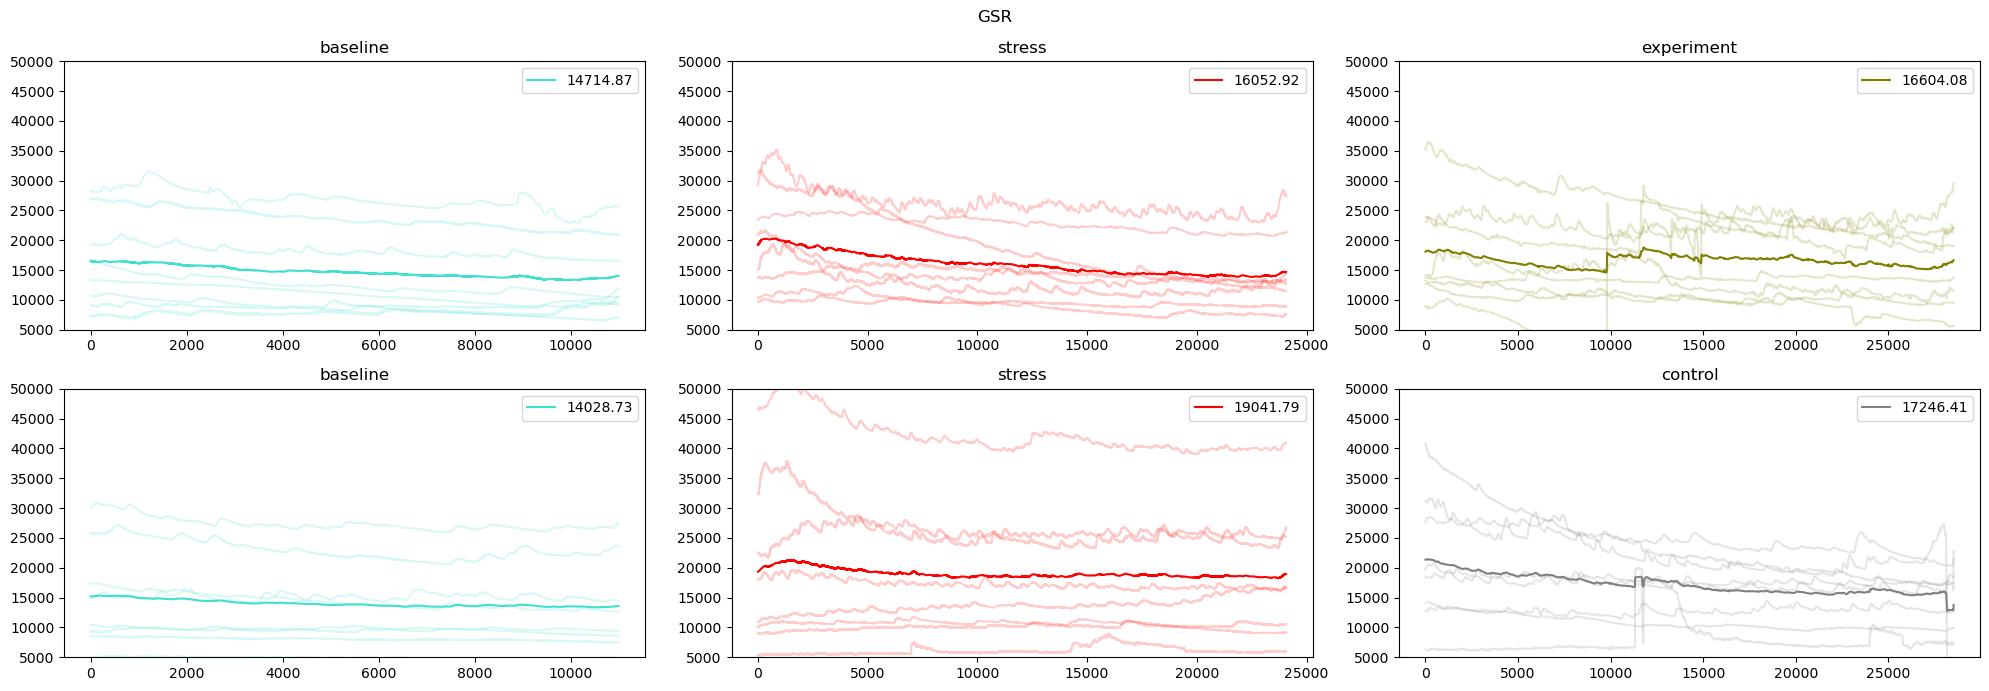

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.suptitle("GSR")
fig.set_figwidth(20)
fig.set_figheight(7)

axs[0][0].set_title("baseline")
axs[0][1].set_title("stress")
axs[0][2].set_title("experiment")
axs[1][0].set_title("baseline")
axs[1][1].set_title("stress")
axs[1][2].set_title("control")


means = {"0_baseline": np.zeros(10999), "0_stress": np.zeros(24070), "0_experiment": np.zeros(28519),
         "1_baseline": np.zeros(10999), "1_stress": np.zeros(24070), "1_control": np.zeros(28519)}
ns = {"0_baseline": 0, "0_stress": 0, "0_experiment": 0,
      "1_baseline": 0, "1_stress": 0, "1_control": 0}
for filename in os.listdir("data/Biometric Data"):
    if filename in ["1.txt", "15.txt", "16.txt"]:
        continue

    df = read_data(f"data/Biometric Data/{filename}", verbose=0)

    row = 0 if "experiment" in df['Phase'].values else 1

    col = {'baseline': 'turquoise', 'stress':'red', 'experiment':'olive', 'control':'grey'}
    for phase, colour in col.items():
        if phase not in df['Phase'].values:
            continue

        start_phase = df.loc[df['Phase']==phase].index.min()
        end_phase = df.loc[df['Phase']==phase].index.max()
        current_phase = df[start_phase:end_phase]

        if phase == "baseline":
            idx = 0
            to_plot = 10999
        elif phase == "stress":
            idx = 1
            to_plot = 24070
        else:
            idx = 2
            to_plot = 28519

        gsr = current_phase['GSR'].values[-to_plot:]
        means[f"{row}_{phase}"] += gsr
        ns[f"{row}_{phase}"] += 1
            
        axs[row][idx].plot(gsr, color=colour, alpha=0.2)
        axs[row][idx].set_ylim(5000, 50000)

plt.tight_layout()

for key in means.keys():
    means[key] /= ns[key]

for row in range(2):
    for idx, phase in enumerate(["baseline", "stress"]):
        axs[row][idx].plot(means[f"{row}_{phase}"], color = col[phase], label = means[f"{row}_{phase}"].mean().round(2))
        axs[row][idx].legend()

axs[0][2].plot(means["0_experiment"], color=col['experiment'], label = means["0_experiment"].mean().round(2))
axs[0][2].legend()
axs[1][2].plot(means["1_control"], color = col['control'], label = means["1_control"].mean().round(2))
axs[1][2].legend()

plt.savefig("figures/GSR.png")




In [21]:
summaries = []
for filename in os.listdir("data/Biometric Data"):
    if filename in ["1.txt", "15.txt", "16.txt"]:
        continue
    df = read_data(f"data/Biometric Data/{filename}", verbose=0)
    summary = get_gsr_summary(df)
    summary['id'] = filename.split('.')[0]
    summary['group'] = 'experiment' if "experiment" in df['Phase'].values else "control"
    summaries.append(summary)

summaries = pd.concat(summaries).reset_index()
summaries.to_csv("results/GSR.csv")

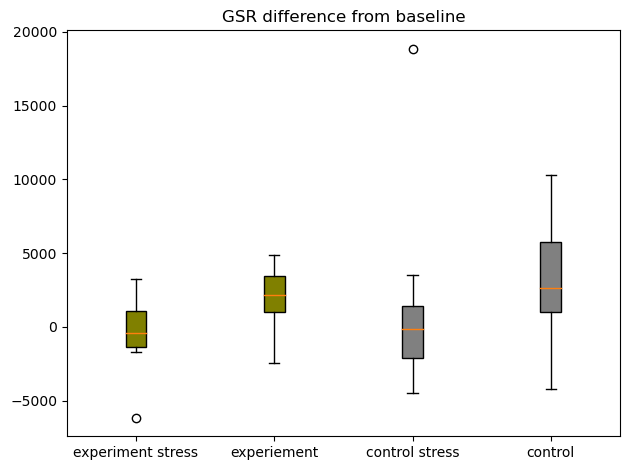

In [22]:
def plot_diff_from_baseline(summaries, title = "GSR difference from baseline", figpath='figures/gsr_diff_from_baseline.png'):
    #experiment
    plt.boxplot(
        [
        summaries.loc[(summaries['Phase'] == "stress") & (summaries['group'] == "experiment")]["diff_from_baseline"].values,
        summaries.loc[summaries['Phase'] == "experiment"]["diff_from_baseline"].values,
        ],
        labels=['experiment stress', 'experiement'], patch_artist=True, boxprops={"facecolor":col['experiment']}, positions= [1, 2])

    # control
    plt.boxplot(
        [
        summaries.loc[(summaries['Phase'] == "stress") & (summaries['group'] == "control")]["diff_from_baseline"].values,
        summaries.loc[summaries['Phase'] == "control"]["diff_from_baseline"].values
        ],
        labels=['control stress', 'control'], patch_artist=True, boxprops={"facecolor":col['control']}, positions= [3, 4])
        
    plt.title(title)
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

plot_diff_from_baseline(summaries)

In [23]:
from scipy.stats import shapiro, mannwhitneyu

experiment = summaries.loc[summaries['Phase'] == "experiment"]["diff_from_baseline"].values
print(shapiro(experiment))
control = summaries.loc[summaries['Phase'] == "control"]["diff_from_baseline"].values
print(shapiro(control))

with open("results/GSR.txt", "w") as f:
    f.write(str(mannwhitneyu(experiment, control)))


ShapiroResult(statistic=0.917940616607666, pvalue=0.41337674856185913)
ShapiroResult(statistic=0.9790047407150269, pvalue=0.9578123092651367)


# HR

In [27]:
offset_scalers = {2:10, 3:6, 5:6, 6:30, 7:30, 10:30,
                 12:30, 13:10, 14:100, 16:10, 18:50, 19:30, 20:10}
summaries = []
for filename in os.listdir("data/Biometric Data"):
    id = int(filename.split('.')[0])
    if id not in offset_scalers:
        continue
    df = read_data(f"data/Biometric Data/{filename}", verbose=0)
    peaks = find_peaks(df, offset_scaler=offset_scalers[id], verbose=0)
    hr, summary = find_heart_rate(df, peaks)
    summary['id'] = id
    summary['group'] = 'experiment' if "experiment" in df['Phase'].values else "control"
    summaries.append(summary)
    
summaries = pd.concat(summaries)

summaries.to_csv("results/HR.csv")


In [25]:
experiment_stress = summaries.loc[(summaries['Phase'] == "stress") & (summaries['group'] == "experiment")]["diff_from_baseline"].values
print(shapiro(experiment_stress))
experiment = summaries.loc[summaries['Phase'] == "experiment"]["diff_from_baseline"].values
print(shapiro(experiment))
control_stress = summaries.loc[(summaries['Phase'] == "stress") & (summaries['group'] == "control")]["diff_from_baseline"].values
print(shapiro(control_stress))
control = summaries.loc[summaries['Phase'] == "control"]["diff_from_baseline"].values
print(shapiro(control))

#if pval too high not different
with open("results/HR.txt", "w") as f:
    f.write(str(mannwhitneyu(experiment, control)))

ShapiroResult(statistic=0.9706448316574097, pvalue=0.8967377543449402)
ShapiroResult(statistic=0.8331307768821716, pvalue=0.11423621326684952)
ShapiroResult(statistic=0.654626190662384, pvalue=0.0011610608780756593)
ShapiroResult(statistic=0.8434957265853882, pvalue=0.10707360506057739)


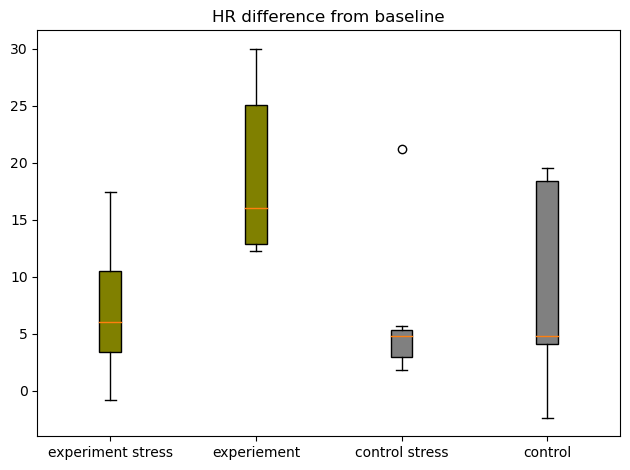

In [179]:
plot_diff_from_baseline(summaries, "HR difference from baseline", "figures/hr_diff_from_baseline.png")


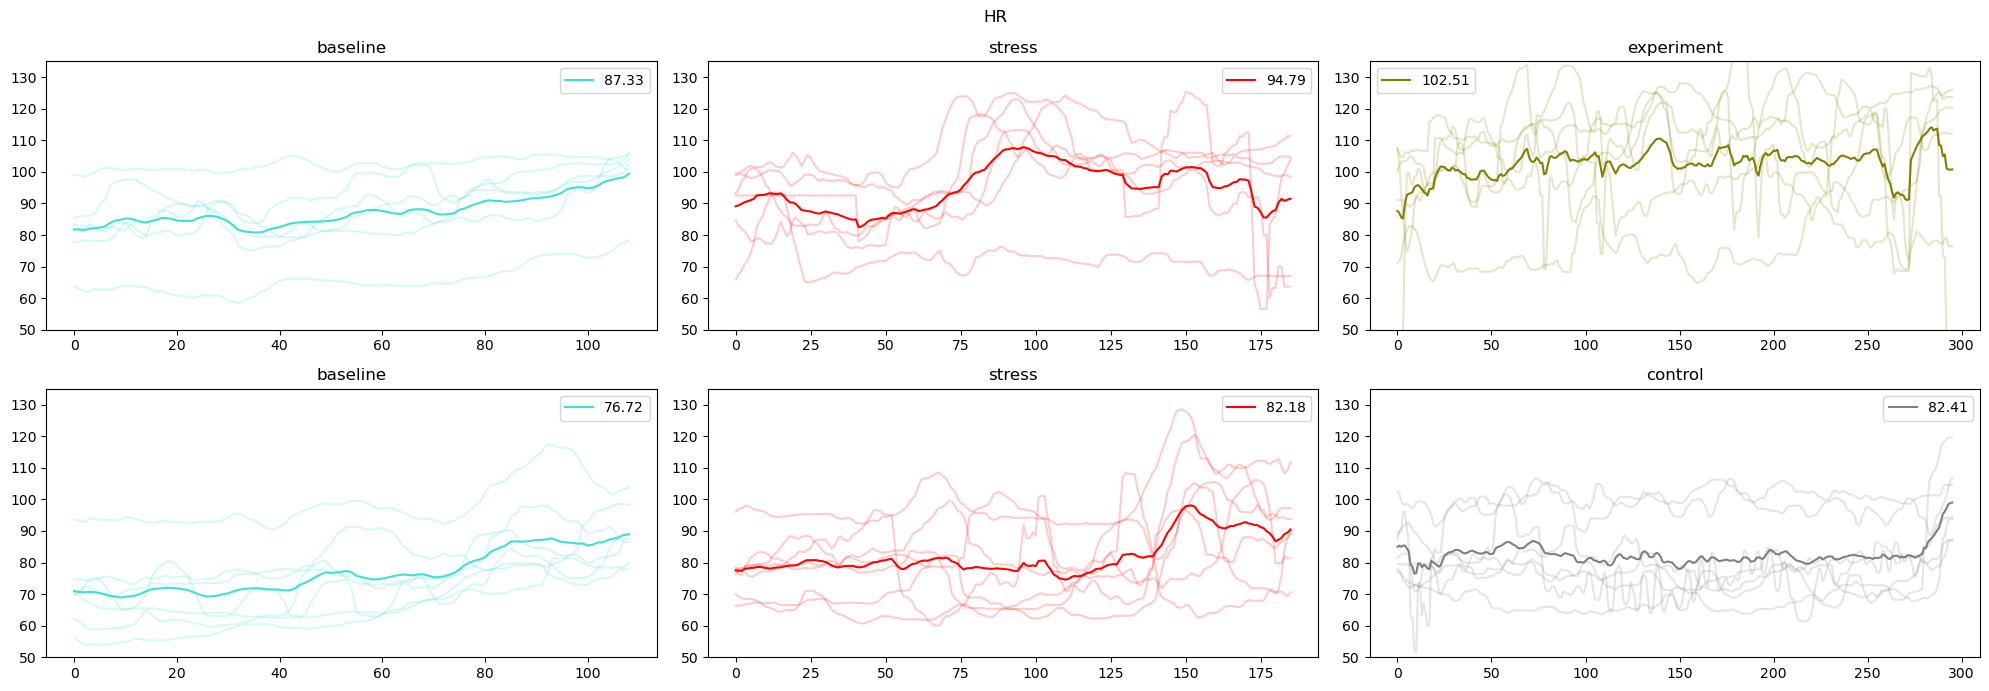

In [180]:
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.suptitle("HR")
fig.set_figwidth(20)
fig.set_figheight(7)

axs[0][0].set_title("baseline")
axs[0][1].set_title("stress")
axs[0][2].set_title("experiment")
axs[1][0].set_title("baseline")
axs[1][1].set_title("stress")
axs[1][2].set_title("control")

means = {"0_baseline": np.zeros(109), "0_stress": np.zeros(186), "0_experiment": np.zeros(296),
         "1_baseline": np.zeros(109), "1_stress": np.zeros(186), "1_control": np.zeros(296)}
ns = {"0_baseline": 0, "0_stress": 0, "0_experiment": 0,
      "1_baseline": 0, "1_stress": 0, "1_control": 0}


for filename in os.listdir("data/Biometric Data"):
    id = int(filename.split('.')[0])
    if id not in offset_scalers:
        continue
    df = read_data(f"data/Biometric Data/{filename}", verbose=0)
    peaks = find_peaks(df, offset_scaler=offset_scalers[id], verbose=0)
    hr, summary = find_heart_rate(df, peaks)
    hr = hr.resample('1s').first()
    hr = hr.fillna(method='ffill')
    row = 0 if "experiment" in df['Phase'].values else 1

    for phase, colour in col.items():
        if phase not in df['Phase'].values:
            continue

        start_phase = hr.loc[hr['Phase']==phase].index.min()
        end_phase = hr.loc[hr['Phase']==phase].index.max()
        current_phase = hr[start_phase:end_phase]

        if phase == "baseline":
            idx = 0
            to_plot = 109
        elif phase == "stress":
            idx = 1
            to_plot = 186
            
        else:
            idx = 2
            to_plot = 296

        current_hr = current_phase['HR_clean'].values[-to_plot-2:-2]
        means[f"{row}_{phase}"] += current_hr
        ns[f"{row}_{phase}"] += 1
            

        axs[row][idx].plot(current_hr, color=col[phase], alpha=0.2)
        axs[row][idx].set_ylim(50, 135)

plt.tight_layout()

for key in means.keys():
    means[key] /= ns[key]

for row in range(2):
    for idx, phase in enumerate(["baseline", "stress"]):
        axs[row][idx].plot(means[f"{row}_{phase}"], color = col[phase], label = means[f"{row}_{phase}"].mean().round(2))
        axs[row][idx].legend()

axs[0][2].plot(means["0_experiment"], color=col['experiment'], label = means["0_experiment"].mean().round(2))
axs[0][2].legend()
axs[1][2].plot(means["1_control"], color = col['control'], label = means["1_control"].mean().round(2))
axs[1][2].legend()
plt.tight_layout()
plt.savefig("figures/HR.png")

,HR,HR_clean,Phase
Time,,,
2023-05-19 15:06:22,225.56391,119.762388,ffill
2023-05-19 15:06:23,106.951872,120.248271,ffill
2023-05-19 15:06:24,120.240481,121.028799,ffill
2023-05-19 15:06:25,119.284294,122.199593,ffill
2023-05-19 15:06:26,114.068441,121.464926,ffill
...,...,...,...
2023-05-19 15:24:55,ffill,ffill,ffill
2023-05-19 15:24:56,ffill,ffill,ffill
2023-05-19 15:24:57,ffill,ffill,ffill
